In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
import tensorflow as tf

# Data preparation

In [3]:
train = pd.read_csv("GOOG.csv")

In [4]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-04-30,304.514435,306.049438,298.364441,300.470734,300.470734,4845900
1,2012-05-01,299.944153,303.823914,298.155792,300.262085,300.262085,4030600
2,2012-05-02,298.657532,302.090179,298.364441,301.667938,301.667938,3243900
3,2012-05-03,302.840302,305.428497,302.507477,303.535797,303.535797,3760200
4,2012-05-04,301.002258,301.980896,296.476715,296.556183,296.556183,4443500


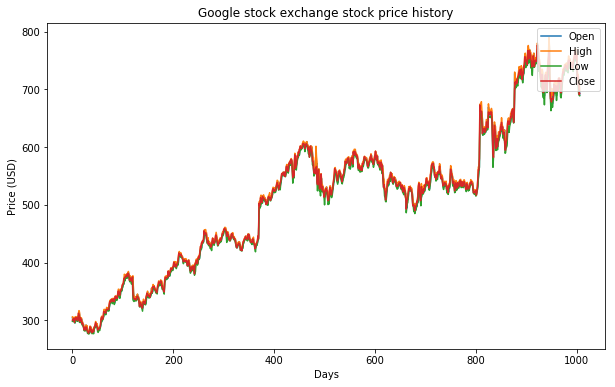

In [36]:
plt.figure(figsize = (10,6))
plt.plot(train["Open"])
plt.plot(train["High"])
plt.plot(train["Low"])
plt.plot(train["Close"])
plt.title('Google stock exchange stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper right')
plt.show()

In [5]:
train_set = train.iloc[:, 1:2].values

In [6]:
t = train.iloc[:, 1:2]

In [7]:
t.head()

,Open
0,304.514435
1,299.944153
2,298.657532
3,302.840302
4,301.002258


In [8]:
train_set

array([[304.514435],
       [299.944153],
       [298.657532],
       ...,
       [707.289978],
       [708.26001 ],
       [690.700012]])

# Feature scaling 

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

# Creating data frame with 60 time steps and 1 output ( Time-Series)

In [10]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Initialize RNN

In [11]:
regressor = Sequential()

# Adding the LSTM layer

In [12]:
from keras.layers import Dropout

In [13]:
# Adding the first LSTM layer and some Dropout regularisation
"""
50 neurons in our layer, return sequences is used when having additional layers.
Input shape only needs the timesteps and input_dim as the batch_size is taken into account automatically.
"""
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
# Ignore 20% of the neurons
regressor.add(Dropout(0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# Adding the second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding the third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding the fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [15]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [16]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
947/947 [==============================] - 52s 54ms/step - loss: 0.0669
Epoch 2/100
947/947 [==============================] - 38s 40ms/step - loss: 0.0090
Epoch 3/100
947/947 [==============================] - 37s 39ms/step - loss: 0.0053
Epoch 4/100
947/947 [==============================] - 36s 38ms/step - loss: 0.0052
Epoch 5/100
947/947 [==============================] - 36s 38ms/step - loss: 0.0050
Epoch 6/100
947/947 [==============================] - 35s 37ms/step - loss: 0.0048
Epoch 7/100
947/947 [==============================] - 35s 37ms/step - loss: 0.0045
Epoch 8/100
947/947 [==============================] - 38s 40ms/step - loss: 0.0049
Epoch 9/100
947/947 [==============================] - 39s 41ms/step - loss: 0.0047
Epoch 10/100
947/947 [==============================] - 39s 41ms/step - loss: 0.0043
Epoch 11/100
947/947 [==============================] - 39s 41ms/step - loss: 0.0041
Epoch 12/100
947/947 [====

# Making the predictions and visualising the results

In [27]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [28]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [29]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [30]:
# Getting the predicted stock price of 2017
# Merge the two datasets together
dataset_total = pd.concat( (train['Open'], dataset_test['Open']), axis = 0 )
# Take the last 60 stock prices and the test values
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# Reformats the data into one column
inputs = inputs.reshape(-1, 1)
# Transforms the inputs to be on the same feature scaling as the training set
inputs = sc.transform(inputs)

# Creating a data structure with 60 timesteps

In [31]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
# Reshape to a new dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [32]:
# Identify the predicted values
predicted_stock_price = regressor.predict(X_test)
# Inverse the scaling to put them back to the normal values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

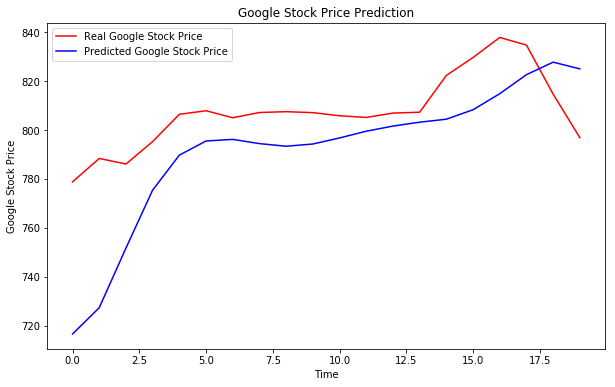

In [37]:
# Visualising the results
plt.figure(figsize=(10,6))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()